In [76]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
from matplotlib import cm
import matplotlib as mpl
# ## Personal Modules
import ReadStandardTimeFill as RSTF
import DenseNet as Dense
import joblib
from scipy import stats
import statsmodels.api as sm
from ipywidgets import FloatProgress
from IPython.display import display
try:pool.close()
except:pass

In [77]:
pd.set_option('max_colwidth',200)
MP=True

cwd = os.getcwd()
def Mapper(AllData,target,name,Fill=False,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
    print(target.params['target'],target.params['Inputs'],
                       target.params['Spath'])
    if DarkTarget is None:
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                       ScalePath=target.params['Spath'],Project=True)
    else:
        target.RST.Data = DarkTarget
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                   ScalePath=target.params['Spath'],Project=True,fillTarget = DarkTarget)
    target.Map(Fill)
    AllData[name] = target.Data_Map[target.target].values
    AllData[name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[name+'_Var_er'] = target.Data_Map['Var_er'].values
    AllData[name+'_CI'] = target.Data_Map['CI'].values
    AllData[name+'_PI'] = target.Data_Map['PI'].values
    return(AllData)

def PooledVar_interval(Data,Vars,mean,n): 
    Ux = 1/(Data[Vars].count(axis=0).sum())*(Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)).sum()
    P1 = ((Data[Vars].count(axis=0)-1)*Data[Vars].std(axis=0)**2+Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)**2).sum()
    P2 = Data[Vars].count(axis=0).sum()*Ux**2
    VarX = 1/(Data[Vars].count(axis=0)-1).sum()*(P1-P2)
    SigmaX = (VarX)**.5
    return(SigmaX)

class ResultMap:
    def __init__(self,Path,target,Test='N/A',Rule=1,alpha = .025,DataName ='AllData.csv',
                 AltPath=None,Scope='Full',FPVars=None):
        self.FPVars = FPVars
        self.target = target        
        self.params = Dense.Params(Path,Scope,target,MP=MP)
        self.params['Dpath'] = Path
        self.RST = RSTF.ReadStandardTimeFill(Path+DataName, self.params['Spath'])
        if AltPath is None:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += target+'/'
        else:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+AltPath+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += AltPath+'/'           
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Nodes'].astype(str)
        self.Records['RMSE']=self.Records['MSE']**.5
        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
        self.Best = self.Records.loc[self.Records.index==Rule]
        self.Model_Selection = self.Best['Model'].values[0]
                
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
        self.params['Spath']=(self.params['Dpath']+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
        prog1 = FloatProgress(min=0, max=self.params['K'],description='Running:')
        display(prog1)
        self.Weights=[]
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),
                                                 range(self.Best['K'].values[0]))):
                prog1.value+=1
                Y = results[0]
                self.Weights.append(results[1])
#                 print(Y)
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
        YTru = self.RST.y+0.0
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        
        for k in range(0,1):
            results=Dense.Load_Model(k,X=X,params=self.params)
            YVar = results[0]
            YVar = YStandard.inverse_transform(YVar)                    
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        try:
            self.Data_Map['key'] = self.RST.Data['key'].values
        except:
            pass
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.025,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5)
        self.Y_fill = Y_fill
        self.Y_fill_bar = Y_fill_bar

In [78]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def RecRead(Path):
    AllRes={}
    for f in ['fco2','fch4']:#,'ER']:
        try:
            AllRes[f]={}
            AllRes[f]['Records']=pd.read_csv(Path+f+'_Runs.csv',index_col=0)
            AllRes[f]['Results']=pd.read_csv(Path+f+'_Results.csv',index_col=0)
            AllRes[f]['Derivatives']={}
            AllRes[f]['SSQ'] ={}
            AllRes[f]['X'] = {}
            AllRes[f]['Yhat'] = {}
            AllRes[f]['Ytrue'] = {}
            AllRes[f]['Outputs'] = {}
        except:
            pass
    return(AllRes)

def DerivKeys(Resluts,col): 
    i =0
    Keys = {}
    for f,r in zip(Results.Factors.values,Results[col].values):
        if r > 0:
            Keys[f]=i
            i += 1
    return(Keys)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Out_Path = 'G:/My Drive/FishIsland_Outputs/'

Path = Out_Path+'Network_Outputs/Arctic_Sci_8Vars/'
DataName = 'FI_Footprints_2022-02-23_2000mx2m.csv'
DataName = 'AWS_FI_Final.csv'

AllRes = RecRead(Path = Path) 
cm_2_in=1/2.54 


In [79]:
for i,F in enumerate(['fco2','fch4']):
    Results = AllRes[F]['Results']
    Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values
    Records = AllRes[F]['Records']
    MBE = []
    MBEs = []
    RMSE = []
    RMSEs = []
    r2 = []
    SDev = []

    for I in Records.index:
        
        y = np.load(Path+F+'_Yhat_'+I+'.npy')#.mean(axis=0)
        x = np.load(Path+F+'_Ytrue_'+I+'.npy')#.mean(axis=0)
        K = y.shape[0]
        df = pd.DataFrame(data={'target':y.flatten(),'y':x.flatten()}).dropna()

        mbe = (np.nansum((x-y),axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))
        MBEs.append(mbe.std())

        rmse = (np.nansum((x-y)**2,axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))**.5
        RMSEs.append(rmse.std())

        MBE.append((df['y']-df['target']).sum()/df['y'].count())
        SDev.append(np.abs(df['y']-df['target']).sum()/df['y'].count()*2**.5)
        RMSE.append(metrics.mean_squared_error(df['y'],df['target'])**.5)
        r2.append(metrics.r2_score(df['y'],df['target']))

    RMSEs=np.array(RMSEs)
    MBEs=np.array(MBEs)

    df = pd.DataFrame(index = Records.index,data = {'RMSE':RMSE,'SE':RMSEs/(K**.5),'MBE':MBE,'MBESE':MBEs/(K**.5),'R2':r2})
    df['Diff']=df['RMSE'].diff()
    Xlbls = []
    df = df.iloc[::-1]
    
    Mn = (df.loc[df['RMSE']==df['RMSE'].min()])
    Mn = (df.loc[df['R2']==df['R2'].max()])
    df['PCT'] = Mn['RMSE'].values[0]/df['RMSE']
    
    df['MX']=df['RMSE']+df['SE']
    df['RMSE_MX']=df['MX']-df['RMSE']
    print(df[['R2','RMSE','SE','MX','RMSE_MX']].round(3)[::-1])
    

          R2   RMSE     SE     MX  RMSE_MX
21_75  0.947  0.345  0.003  0.347    0.003
8_75   0.931  0.391  0.002  0.393    0.002
          R2   RMSE     SE     MX  RMSE_MX
21_43  0.742  6.394  0.048  6.442    0.048
8_43   0.730  6.542  0.045  6.587    0.045


In [88]:
Site = None
co2_Model_Index = '8_75'
ch4_Model_Index = '8_43'   
fco2 = ResultMap(Path,'fco2',Test='N/A',Rule=co2_Model_Index,DataName=DataName)
fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName=DataName)
# ER = ResultMap(Path,'ER',Test='N/A',Rule=co2_Model_Index,DataName=DataName,AltPath='fco2')
fch4_FP = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName=DataName)
T30 = fco2.RST.Master.copy()
T30 = T30.loc[T30.index.year>2008].copy()
T30 = T30.loc[T30.index.year<2020].copy()
mult = {'fco2':1,#(1e-6 * 12.0107 *1800),
        'ER':1,#(1e-6 * 12.0107 *1800),
        'fch4':1#,#(1e-9 * 12.0107 *1800)
       }
T30.head()

,datetime,fch4,fco2,ch4_flux,co2_flux,Air_Temp,Rainfall,wind_speed,Wind_Direction,Net_SW,...,PPFD_Avg_Diff,u*_FO,u*_Diff,Table_1_FO,Table_1_Diff,Active_Layer_1_FO,Active_Layer_1_Diff,DOY2,HR,ER
datetime,,,,,,,,,,,,,,,,,,,,,
2009-05-01 00:00:00,2009-05-01 00:00:00,NaN,NaN,NaN,NaN,-1.0,NaN,2.1,78.0,-2.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.0,0.0,0
2009-05-01 01:00:00,2009-05-01 01:00:00,NaN,NaN,NaN,NaN,-1.3,NaN,1.9,102.4,-2.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.0,1.0,0
2009-05-01 02:00:00,2009-05-01 02:00:00,NaN,NaN,NaN,NaN,-1.1,NaN,2.2,154.3,-1.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.0,2.0,0
2009-05-01 03:00:00,2009-05-01 03:00:00,NaN,NaN,NaN,NaN,-1.4,NaN,2.4,155.8,-1.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.0,3.0,0
2009-05-01 04:00:00,2009-05-01 04:00:00,NaN,NaN,NaN,NaN,-1.2,NaN,2.0,168.4,-1.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.0,4.0,0


In [90]:
print(T30['Season'].describe())

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Season, dtype: float64


In [81]:
T30 = Mapper(T30,fch4,'NME_est',Fill = False)
T30 = Mapper(T30,fco2,'NEE_est',Fill = False)

T30_Dark = T30.copy()
T30_Dark['PPFD_Avg'] = 0
T30_Dark['Daytime'] = 0


T30_FP = T30.copy()
T30_FP['Polygon'] = T30_FP['Polygon_Obs']
T30_FP['Rim'] = T30_FP['Rim_Obs']

T30 = Mapper(T30,fch4_FP,'NME_est_FP',Fill = False,DarkTarget=T30_FP)
# T30 = Mapper(T30,ER,'ER_est',Fill = False,DarkTarget=T30_Dark)

print(T30)

fch4 ['u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Polygon', 'Rim'] G:/My Drive/FishIsland_Outputs/Network_Outputs/Arctic_Sci_8Vars/fch4/8_43/


FloatProgress(value=0.0, description='Running:', max=30.0)

fco2 ['VPD', 'wind_speed', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime'] G:/My Drive/FishIsland_Outputs/Network_Outputs/Arctic_Sci_8Vars/fco2/8_75/


FloatProgress(value=0.0, description='Running:', max=30.0)

fch4 ['u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Polygon', 'Rim'] G:/My Drive/FishIsland_Outputs/Network_Outputs/Arctic_Sci_8Vars/fch4/8_43/


FloatProgress(value=0.0, description='Running:', max=30.0)

                                datetime  fch4  fco2  ch4_flux  co2_flux  \
datetime                                                                   
2009-05-01 00:00:00  2009-05-01 00:00:00   NaN   NaN       NaN       NaN   
2009-05-01 01:00:00  2009-05-01 01:00:00   NaN   NaN       NaN       NaN   
2009-05-01 02:00:00  2009-05-01 02:00:00   NaN   NaN       NaN       NaN   
2009-05-01 03:00:00  2009-05-01 03:00:00   NaN   NaN       NaN       NaN   
2009-05-01 04:00:00  2009-05-01 04:00:00   NaN   NaN       NaN       NaN   
...                                  ...   ...   ...       ...       ...   
2019-10-31 19:00:00  2019-10-31 19:00:00   NaN   NaN       NaN       NaN   
2019-10-31 20:00:00  2019-10-31 20:00:00   NaN   NaN       NaN       NaN   
2019-10-31 21:00:00  2019-10-31 21:00:00   NaN   NaN       NaN       NaN   
2019-10-31 22:00:00  2019-10-31 22:00:00   NaN   NaN       NaN       NaN   
2019-10-31 23:00:00  2019-10-31 23:00:00   NaN   NaN       NaN       NaN   

           

In [82]:
mult = {'fco2':1,#(1e-6 * 12.0107 *1800),
        'ER':1,#(1e-6 * 12.0107 *1800),
        'fch4':1#,#(1e-9 * 12.0107 *1800)
       }

for target,name in zip([fch4,fco2,fch4_FP],['NME','NEE','NME_FP']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30['Fill']  = target.Y_fill[i,:]
        B = target.RST.Master[target.target].fillna(T30['Fill'])
        T30[name+'_'+str(i)] = target.RST.Master[target.target].fillna(T30['Fill'])#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)*mult[target.target]
    sp = PooledVar_interval(T30,target.cols,'Mean',n=30)
    target.PooledVar = sp
    target.Mean = T30[name].mean()

Cols=[]
for i in range(target.Y_fill.shape[0]):
    T30['CBal_'+str(i)]=T30['NME_'+str(i)]*mult['fch4']+T30['NEE_'+str(i)]*mult['fco2']
    Cols.append('CBal_'+str(i))
    
T30['CBal'] = T30[Cols].mean(axis=1)

for target,name in zip([fch4,fco2,fch4_FP],['NME_est','NEE_est','NME_est_FP']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30[name+'_'+str(i)]  = target.Y_fill[i,:]#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    
    sp = PooledVar_interval(T30,[name+'_Var_reg',name+'_Var_er'],'Mean',n=2)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')

Done


In [83]:
def MI(Data,Vars,JustBetween=False):
#     print()
    Mean = Data[Vars].mean().mean()
    WithinVariance = (Data[Vars].std()**2).mean()
    BetweenVariance = 1/(Data[Vars].shape[1]-1)*((Mean-Data[Vars].mean())**2).mean()
    TotalVariance = WithinVariance + (1+1/Data[Vars].shape[1])*BetweenVariance
    if JustBetween == False:
        return(TotalVariance)
    else:
        return(BetweenVariance)
T30['DOY']=T30.index.dayofyear

Start = 0
End = 365

NDVI_Thresh = 0.388104
NDVI_Thresh = 0.244049
for Y in range(2009,2020):
    Estimates = []
    CIs = []
    SE = []
    IntType = []
    Scale = []
    Samples = []
    Fluxes = []
    Type = []
    Targets = {'NEE':fco2,
               'NME':fch4,
               'NEE_est':fco2,
               'NME_est':fch4,
               'NME_est_FP':fch4_FP,
#            'ER_est':ER,
              }
    Temp = T30.loc[(T30['DOY']>=Start)&(T30['DOY']<=End)&(T30.index.year==Y)]
    Vars = ['NEE_est','NME_est','NME_est_FP']
    for Var in Vars:
        target = Targets[Var]
        if Var == 'NEE_est' or Var == 'NME_est' or Var == 'ER_est' or Var == 'NME_est_FP':
            CIPI = 'CI'
            if Var != 'NME_est_FP':
                Fluxes.append(Var.split('_')[0])
            else:
                Fluxes.append('NME_FP')
            
            Type.append('EC Obs.')
            std = MI(Temp,target.cols)**.5*1*mult[target.target]
            Int=Temp[Var+'_CI'].mean()#(std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())
            
        SE.append(std)
        U = Temp[Var].sum()/(Temp.shape[0]/1)#*mult[target.target]
        Estimates.append(U)
        CIs.append(Int)
        Scale.append('Footprint')
        Samples.append(Temp[Var].count())
        IntType.append(CIPI)
    std = MI(Temp,Cols)**.5
    Int = (std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp['CBal'].count())
    Data = {'Flux':Fluxes,'Scale':Scale,'Estimates':Estimates,
            '95% CI/PI':CIs,'SE':SE,'Interval Type':IntType,'N':Samples,'Type':Type}
    if Y == 2009:
        All = pd.DataFrame(data = Data)
        All['Year'] = Y
    else:
        More = pd.DataFrame(data = Data)
        More['Year'] = Y
        All = All.append(More)
All = All.reset_index()

All = All.loc[((((All['Flux']=='NME')|(All['Flux']=='NME_FP'))&(All['Year']!=2009))|(All['Flux']=='NEE'))].copy()
All.to_csv('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Annual_est.csv')
All.loc[All['Flux']=='NME'].sort_values(by='Estimates')

All['CI_Min']=All['Estimates']-All['95% CI/PI']
All['CI_Max']=All['Estimates']+All['95% CI/PI']
All[['Year','Estimates','95% CI/PI','Flux','CI_Min','CI_Max']].set_index(['Flux','Year']).to_csv('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Annual_est.csv')
NEE = All.loc[All['Flux']=='NEE']
NME = All.loc[All['Flux']=='NME']
print(NEE.loc[NEE['Estimates']==NEE['Estimates'].max(),['Estimates','95% CI/PI','CI_Min','CI_Max']])
print(NEE.loc[NEE['Estimates']==NEE['Estimates'].min(),['Estimates','95% CI/PI','CI_Min','CI_Max']])
print()
print(NME.loc[NME['Estimates']==NME['Estimates'].max(),['Estimates','95% CI/PI','CI_Min','CI_Max']])
print(NME.loc[NME['Estimates']==NME['Estimates'].min(),['Estimates','95% CI/PI','CI_Min','CI_Max']])

All

    Estimates  95% CI/PI    CI_Min    CI_Max
12   0.999963    0.85793  0.142033  1.857894
    Estimates  95% CI/PI    CI_Min    CI_Max
30   0.593635   0.749608 -0.155973  1.343244

    Estimates  95% CI/PI    CI_Min     CI_Max
13   19.58103  23.202837 -3.621807  42.783867
    Estimates  95% CI/PI    CI_Min     CI_Max
22  16.489069  24.391131 -7.902062  40.880199


,index,Flux,Scale,Estimates,95% CI/PI,SE,Interval Type,N,Type,Year,CI_Min,CI_Max
0,0,NEE,Footprint,0.948416,0.901566,2.361913,CI,4416,EC Obs.,2009,0.046850,1.849982
3,0,NEE,Footprint,0.847746,0.844478,2.218812,CI,4416,EC Obs.,2010,0.003268,1.692224
4,1,NME,Footprint,17.314998,24.227426,17.031189,CI,4416,EC Obs.,2010,-6.912428,41.542424
5,2,NME_FP,Footprint,17.314998,24.227426,17.031189,CI,4416,EC Obs.,2010,-6.912428,41.542424
6,0,NEE,Footprint,0.767645,0.841789,2.256043,CI,4416,EC Obs.,2011,-0.074144,1.609434
7,1,NME,Footprint,18.285744,24.181451,16.770877,CI,4416,EC Obs.,2011,-5.895707,42.467194
8,2,NME_FP,Footprint,18.285744,24.181451,16.770877,CI,4416,EC Obs.,2011,-5.895707,42.467194
9,0,NEE,Footprint,0.820396,0.817107,2.191116,CI,4416,EC Obs.,2012,0.003289,1.637503
10,1,NME,Footprint,18.439789,24.446538,17.388690,CI,4416,EC Obs.,2012,-6.006749,42.886328
11,2,NME_FP,Footprint,18.439789,24.446538,17.388690,CI,4416,EC Obs.,2012,-6.006749,42.886328


# Save Out

<IPython.core.display.Javascript object>


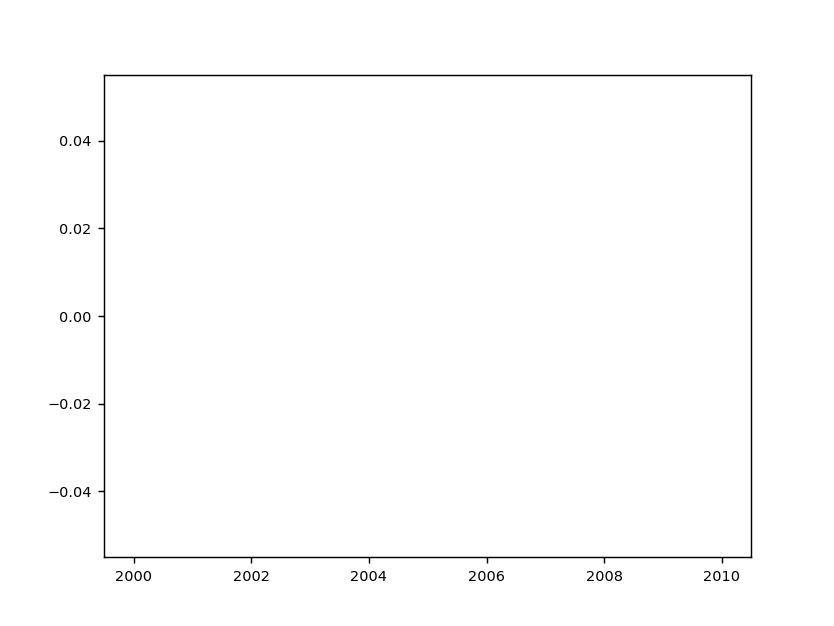

(48576, 303)


In [87]:
%matplotlib notebook
# T30['Season_BU']=T30['Season'].copy()
# T30.loc[T30['Season']

# T30.loc[T30['Snow']==0,'Snow']=-1
# T30['Season']=(T30['Snow']*T30['Freezing'])**2

# T30.loc[T30['Season']<1,'Season']=np.nan

plt.figure()
# plt.plot(T30['Freezing'])
plt.plot(T30['Season'])

# print(T30.groupby(T30.index.month).count())

Out = T30[T30.columns[T30.columns.str.contains('ER_')==False]].copy()#[160:2000]
Out = Out.drop(columns=['Daytime.1'])
print(Out.shape)

# Out.to_csv(Out_Path+'Upscaled_Estimates.csv')

## Validation

r2 2.11
RMSE 11.85
MAE 9.5
                            OLS Regression Results                            
Dep. Variable:             NME_est_FP   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     922.8
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          6.64e-127
Time:                        13:34:56   Log-Likelihood:                -2271.5
No. Observations:                 653   AIC:                             4547.
Df Residuals:                     651   BIC:                             4556.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0416    

<IPython.core.display.Javascript object>


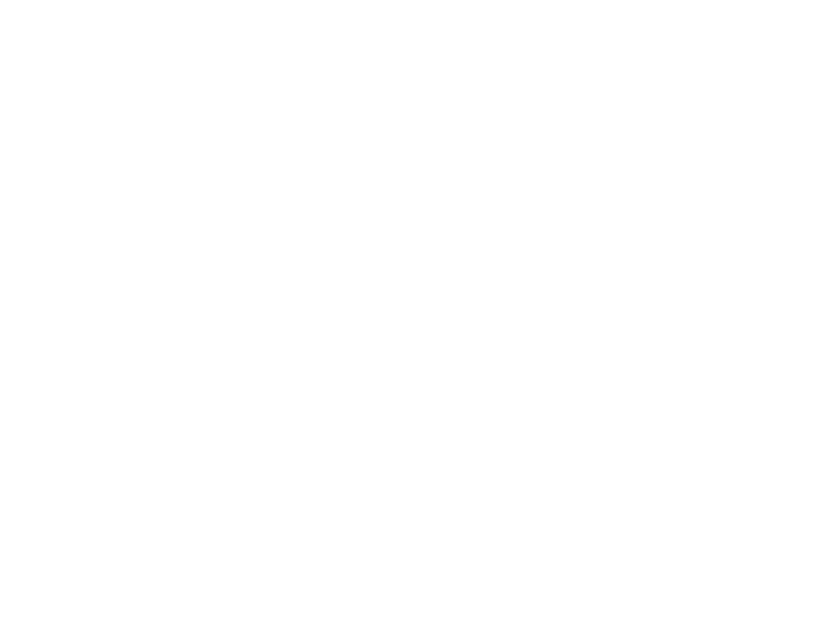

In [85]:
X = 'fch4'
# y = 'NME_FSO'
y = 'NME_est_FP'

# X = 'fco2'
# # y = 'NEE_FSO'
# y = 'NEE_est'


DNA=(T30[[X,y]].dropna())
print('r2',(metrics.r2_score(DNA[X],DNA[y])*100).round(2))
print('RMSE',(metrics.mean_squared_error(DNA[X],DNA[y])**.5).round(2))
print('MAE',(metrics.mean_absolute_error(DNA[X],DNA[y])).round(2))

X2 = sm.add_constant(DNA[X])
est = sm.OLS(DNA[y], X2)
est2 = est.fit()
print(est2.summary())
with open('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/'+X[0]+'_v_'+y+'_summary.txt', 'w') as fh:
    fh.write(est2.summary().as_text())
plt.figure()
plt.scatter(T30[X],T30[y])

<IPython.core.display.Javascript object>


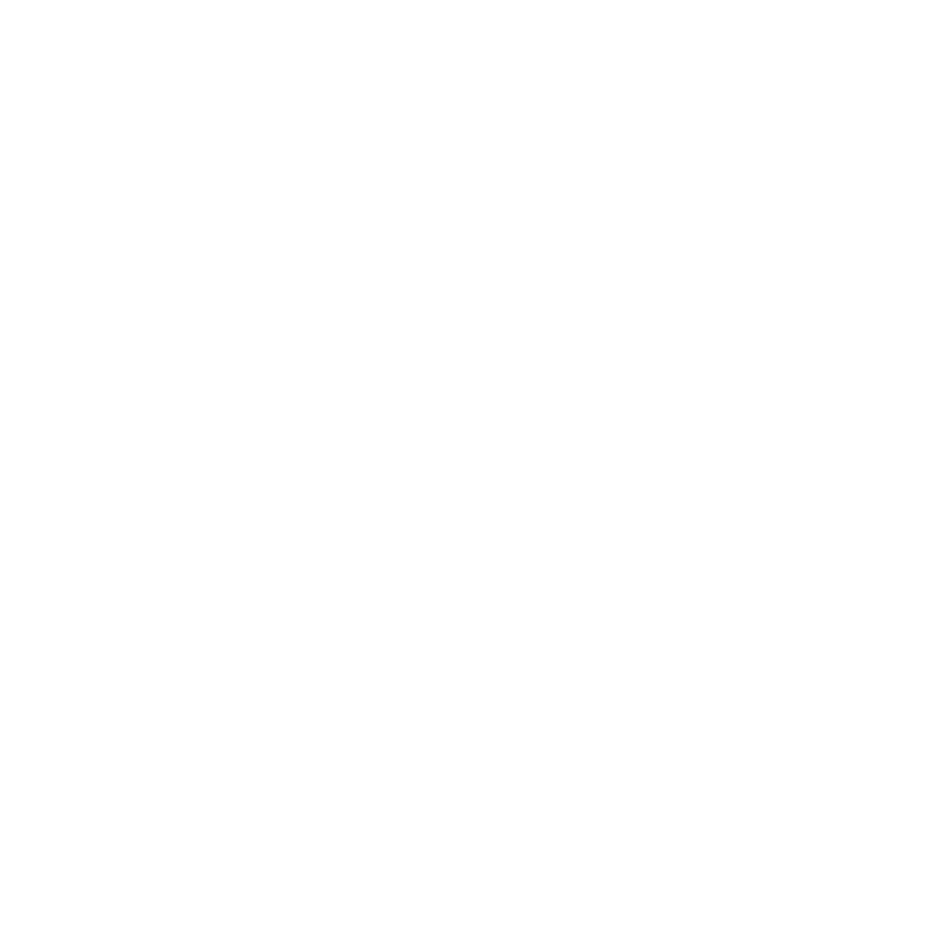

IndexError: index 0 is out of bounds for axis 0 with size 0

In [86]:
Units = ['umol m2 s',
'nmol m2 s',
'G'
]
T30['On_Off'] = T30['Season'].copy()
T30.loc[T30['On_Off'].isnull()==False,'On_Off']=1

Aliases = ['NEE',
'NME','Net C Balance']

Start = 174
End = 256

Yearly = T30[['NEE_est','NME_est','NEE_est_CI','NME_est_CI']].groupby(T30.index.dayofyear).apply(lambda g: g.mean(skipna=False))
# .mean()
import matplotlib.patheffects as pe

fig,axes = plt.subplots(3,figsize=(18.2*cm_2_in, 18.2*cm_2_in))

GS = T30.loc[(#(T30.index.dayofyear>=Start)&(T30.index.dayofyear<=End)&
             (T30.index.year>=2009)&(T30.index.year<=2019))].copy()

nee = All.loc[All['Flux']=='NEE']
nme = All.loc[All['Flux']=='NME']

norm = mpl.colors.Normalize(vmin=0, vmax=10)
Colors = []
for i in range(0,10):
    rgba_color = cm.bwr(norm(i)) 
    Colors.append(rgba_color)

mult = {'fco2':(1e-6 * 12.0107 *3600),
        'fch4':(1e-9 * 12.0107 *3600)
       }

GS['NEE_est_c'] = GS['NEE_est']*mult['fco2']
GS['NME_est_c'] = GS['NME_est']*mult['fch4']
GS['C']=(GS['NEE_est_c']+GS['NME_est_c'])*GS['On_Off']
GS['Air_Temp']=GS['Air_Temp']*GS['On_Off']

Yz = GS.loc[GS.index.year>2009].resample('Y').sum()['C'].sort_values(ascending=False)

i = Yz.index.year.shape[0]-1
Mx,Pd,Sm,CO,CH = [],[],[],[],[]
Yix = []
Smin = 200
Emax = 200

ax=axes[2]
for y in Yz.index.year:#[::-1]:
    if y >=2009 and y<=2019:
        Yix.append(y)
        Year = GS.loc[GS.index.year==y,['C','NEE_est_c','NME_est_c']].resample('D').sum().cumsum().copy()
        Year[['On_Off','Air_Temp']] = GS.loc[GS.index.year==y,['On_Off','Air_Temp']].resample('D').mean().copy()
        S = (Year.loc[Year['On_Off'].isnull()==False].index.dayofyear[0])
        if S<Smin:
            Smin=S*1
        E = (Year.loc[Year['On_Off'].isnull()==False].index.dayofyear[-1])
        if E>Emax:
            Emax=E*1
        Mx.append(Year['C'].min())
        Pd.append(Year.loc[Year['C']==Year['C'].min()].index.dayofyear.values[0])
        Sm.append(Year['C'][-1:].values[0])
        ax.plot(Year.index.dayofyear,Year['C']*Year['On_Off'],
                color=Colors[i],label=y,lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
        Year['C'] = Year['C']*Year['On_Off']
                
        CO.append(Year['NEE_est_c'][-1:].values[0])
        CH.append(Year['NME_est_c'][-1:].values[0])
        
        i -=1
Cbal = pd.DataFrame(index=Yix,data={'Max':Mx,'Max_Date':Pd,'Total':Sm,'CO2':CO,'CH4':CH})
Cbal['Frac'] = Cbal['CH4']/Cbal['CO2'].abs()
print(Cbal['Frac'].describe())
print(Cbal.sort_values(by='Total'))

ax.grid()
ax.set_title('c. Growing On_Off C Balance',loc='left')
ax.set_ylabel('g C $m^{-2}$')
ax.set_xlabel('DOY')
ax.set_xlim(Start,End)
ax.legend(ncol=2,columnspacing=1,handlelength=1)

# ax.legend()
ax=axes[0]
ax.set_title('a. Growing On_Off NEE',loc='left')

ax=axes[1]
ax.set_title('b. Growing On_Off NME',loc='left')
j=0
Xl1,Xl2=Smin-5,Emax+5

axes[0].plot([Xl1,Xl2],[0,0],color='k')
axes[1].plot([Xl1,Xl2],[0,0],color='k')
axes[2].plot([Xl1,Xl2],[0,0],color='k')
ax=axes[0]

ax.plot(Yearly['NEE_est']-Yearly['NEE_est_CI'],
        linestyle='--',color='#81db9c',lw=1, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
ax.plot(Yearly['NEE_est']+Yearly['NEE_est_CI'],
        linestyle='--',color='#81db9c',lw=1, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
ax.plot(Yearly['NEE_est'],
        color='#81db9c',lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])

# e
ax=axes[1]
ax.plot(Yearly['NME_est']-Yearly['NME_est_CI'],
        linestyle='--',color='#b57ed6',lw=1, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
ax.plot(Yearly['NME_est']+Yearly['NME_est_CI'],
        linestyle='--',color='#b57ed6',lw=1, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
ax.plot(Yearly['NME_est'],
        color='#b57ed6',lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])

j=0
for ax in axes:#[axes[0],axes[1]]:
    ax.axvspan(Xl1-1,Start,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax.axvspan(End,Xl2+1,facecolor=[.97,.97,.97,.65],edgecolor='k')
#     ax.set_xlim(Xl1,Xl2)
#     ax.grid()
#     ax.set_title(Aliases[j])
    ax.set_ylabel(Units[j])
    yl = ax.get_ylim()
    print(Aliases[j])
    print(Start,End,yl[0],yl[1])
    ax.set_xlim(Xl1,Xl2)
    ax.set_axisbelow(True)
    ax.grid(color='gray', linestyle='dashed')
    j+=1
# axes[0].set_ylim(-2.2,2.2)
# axes[1].set_ylim(0,44)

plt.tight_layout()
print(All.loc[((All['Year']==2017)&(All['Flux']=='NEE')),'Estimates'])
print(All.loc[((All['Year']==2017)&(All['Flux']=='NEE')),'95% CI/PI'])
print(All.loc[((All['Year']==2017)&(All['Flux']=='NME_FP')),'Estimates'])
print(All.loc[((All['Year']==2017)&(All['Flux']=='NME_FP')),'95% CI/PI'])
Yearly.columns.values
plt.savefig('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Modeled_Fluxes_OLS.jpg',dpi=600)

## Satelite

In [ ]:
Coverage = T30.loc[((T30.index.month>=5)&(T30.index.month<=10))].copy()
#     T30['Season'].isnull()==False]
Coverage = Coverage.groupby(Coverage.index.date).mean()
Total = Coverage['DOY'].count()
print(Total)
print('NDVI')
Missing = Coverage.loc[Coverage['ndvi_FI_LCP'].isnull()==True,'NDVI_interp'].count()
print(Missing,Missing/Total)


print('NDSI')
Missing = Coverage.loc[Coverage['NDSI_FI_LCP'].isnull()==True,'NDSI_interp'].count()
print(Missing,Missing/Total)
# Coverage[['Season','ndvi_FI']]

In [ ]:
GPP_Daily = T30.loc[((T30.index.dayofyear>=174)&(T30.index.dayofyear<=256)),
                    ['GPP_interp','NDVI_interp','NEE_est','Season']].resample('D').mean().dropna()

CO2 = T30[['GPP_interp','NDVI_interp','NEE_est','Season']].dropna()

CO2['Ix'] = CO2.index.year#+CO2.index.month
CO2_ix = CO2.loc[((CO2.index.month>=7)&(CO2.index.month<=8))].groupby('Ix').mean()
CO2_ix['GPP_Max'] = CO2.loc[((CO2.index.month>=7)&(CO2.index.month<=8))].groupby('Ix').max()['GPP_interp']

print((CO2_ix.corr()**2)['NEE_est'])
print()

print((GPP_Daily.corr()**2)['NEE_est'])
fig,ax=plt.subplots(1,2)
# ax[0].scatter(GPP_Daily['GPP_interp'],GPP_Daily['NEE_est'])
# ax[1].scatter(GPP_Daily['NDVI_interp'],GPP_Daily['NEE_est'])
ax[0].scatter(CO2_ix['GPP_interp'],CO2_ix['NEE_est'])
ax[1].scatter(CO2_ix['NDVI_interp'],CO2_ix['NEE_est'])

In [ ]:

# GPP = pd.read_csv('G:\\My Drive\\earthengine/GPP_Multi_Scale.csv',
#                   parse_dates=['date'],na_values=-9999,index_col=['date']).dropna()
# GPP = GPP.set_index(pd.to_datetime(GPP.index))
# # GPP = GPP.resample('1D').interpolate()/8

# PsnNet = pd.read_csv('G:\\My Drive\\earthengine/PsnNet.csv',
#                   parse_dates=['date'],na_values=-9999,index_col=['date']).dropna()
# PsnNet = PsnNet.set_index(pd.to_datetime(PsnNet.index))

# NDVI = pd.read_csv('G:\\My Drive\\earthengine/NDVI_NBAR_FP_New.csv',
#                   parse_dates=['date'],na_values=-9999,index_col=['date']).dropna()
# NDVI = NDVI.set_index(pd.to_datetime(NDVI.index))

# GPP['RSMP_Key'] = GPP.index.copy()
# NDVI['RSMP_Key2'] = NDVI.index.copy()

# Test = T30.join(NDVI,how='outer',rsuffix='R').join(GPP,how='outer',rsuffix='R').join(PsnNet,how='outer',rsuffix='R')
# Test = Test.loc[((Test.index.year>2008)&(Test.index.year<2020))]


# Test['RSMP_Key']=Test['RSMP_Key'].ffill()


# Test2 = Test.groupby('RSMP_Key').mean()

# print(GPP)

# Test2['ndvi_diff']=Test2['NDVI_interp'].diff()

# Test3=Test2.loc[((Test2.index.dayofyear>=174)&
#           (Test2.index.dayofyear<=256-7))]

# y = 'NEE_est'

# for X,y in zip(['ndvi_diff','GPP_FI','ndvi_diff'],['NEE_est','NEE_est','NME_est']):
#     DNA = Test3[[X,y]].dropna()
#     X2 = sm.add_constant(DNA[X])
#     est = sm.OLS(DNA[y], X2)
#     est2 = est.fit()
#     print()
#     print(X)
#     print(stats.pearsonr(DNA[X], DNA[y]))
#     print(est2.summary())
#     with open('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/'+X+'v'+y+'_summary.txt', 'w') as fh:
#         fh.write(est2.summary().as_text())


# Test['RSMP_Key']=Test['RSMP_Key'].ffill()

# Test4 = Test.groupby('RSMP_Key').mean()

# X = ['NDVI_interp','ndvi_diff']
# X = ['NDVI_interp']
# # X = ['ndvi_diff']
# # X = ['GPP_FIR']
# DNA = Test3[X+[y]].dropna()
# X2 = sm.add_constant(DNA[X])
# est = sm.OLS(DNA[y], X2)
# est2 = est.fit()
# print(metrics.mean_squared_error(DNA[y],est2.predict(X2)))
# print()
# print(X)
# print(est2.summary())
# # with open('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/'+X+'v'+y+'_summary.txt', 'w') as fh:
# #     fh.write(est2.summary().as_text())

In [ ]:

# # T30.loc[((T30.index.month==7)&(T30.index.year<2016)),['NEE_est','NME_est']].mean()
# T30.columns.str.contains('ndvi')

In [ ]:

# GS = T30.loc[((T30.index.dayofyear>=Start)&(T30.index.dayofyear<=End)&
#              (T30.index.year>2008)&(T30.index.year<2020))].copy()


# Non_Inputs=['NEE_est','NME_est',
#             'GPP_FI','NDVI_interp',
# #             'ndvi_diff'#,'GPP_diff'
#            ]

# Sat_Data = ['GPP_FI',
#        'GPP_FP', 'NDVI_interp', 'ndvi_FP']

# BU = T30[Sat_Data].copy()
# T30[Sat_Data]=T30[Sat_Data].interpolate()
# # T30['ndvi_diff']=T30['NDVI_interp'].diff(24)
# # T30['GPP_diff']=T30['GPP_FI'].diff(24)
# # GS['ndvi_diff']=T30['NDVI_interp'].diff(24)
# # GS['GPP_diff']=T30['GPP_FI'].diff(24)

# Annual = GS[Non_Inputs].groupby(GS.index.year).mean()
# Annual['NDVI_interp_max'] = GS['NDVI_interp'].groupby(GS.index.year).max()

# Day8 = GS[Non_Inputs].resample('8D').mean()
# Day8['ndvi_diff'] = Day8['NDVI_interp'].diff()

# D8 = Day8.copy()
# D8 = D8.loc[((D8.index.dayofyear>=Start)&(D8.index.dayofyear<=End)&
#         (D8.index.year>=2009)&(D8.index.year<=2018)),Non_Inputs
#        ].corr()[['NEE_est','NME_est']][2:]

# # D = GS.resample('D').mean()

# Day = GS[Non_Inputs].resample('D').mean()
# Day['ndvi_diff']=Day['NDVI_interp'].diff()
# D = Day.corr()[['NEE_est','NME_est']][2:]

# L7 = pd.read_csv('FP_Landsat7.csv',parse_dates=['system:time_start'],index_col=['system:time_start']).resample('Y').max()
# L7.index=L7.index.year
# L8 = pd.read_csv('FP_Landsat8.csv',parse_dates=['system:time_start'],index_col=['system:time_start']).resample('Y').max()
# L8.index=L8.index.year

# print((Annual.join(L8).corr()**2)[['NEE_est','NME_est','NDVI_LS8']].round(2))
# # print((Annual.join(L7).corr()**2)[['NEE_est','NME_est','NDVI_LS7']].round(2))

# Annual= Annual.join(L7,how='inner')#.join(L8,how='outer').

# A = Annual.corr()[['NEE_est','NME_est']][2:]
# print((A**2).round(2)*np.sign(A))
# print((D8**2).round(2)*np.sign(D8))
# print((D**2).round(2)*np.sign(D))

# Annual= Annual.join(L8,how='outer')

In [ ]:
# fig,axes=plt.subplots(2,figsize=(18.2*cm_2_in, 12.2*cm_2_in),sharex=True)
# Yearly = T30[['NEE_est','NME_est']].groupby(T30.index.dayofyear).mean()
# Annual_S = T30[['NEE_est','NME_est']].groupby(T30.index.dayofyear).std()#.rolling(8).mean()
# ax=axes[0]
# ax.plot(Yearly['NEE_est']+Annual_S['NEE_est']/11**.5*stats.t.ppf(1-0.025,11),color='grey')
# ax.plot(Yearly['NEE_est']-Annual_S['NEE_est']/11**.5*stats.t.ppf(1-0.025,11),color='grey')
# ax.plot(Yearly['NEE_est'],color='red')

# ax=axes[1]
# ax.plot(Yearly['NME_est']+Annual_S['NME_est']/10**.5*stats.t.ppf(1-0.025,10),color='grey')
# ax.plot(Yearly['NME_est']-Annual_S['NME_est']/10**.5*stats.t.ppf(1-0.025,10),color='grey')
# ax.plot(Yearly['NME_est'],color='purple')

# Variables = ['NEE_est',
# 'NME_est','C']

# Aliases = ['NEE',
# 'NME','Net C Balance']

# Units = ['umol m2 s',
# 'nmol m2 s',
# 'G'
# ]

# j=0
# Xl1,Xl2=Start-35,End+35

# axes[0].plot([Xl1,Xl2],[0,0],color='k')
# axes[1].plot([Xl1,Xl2],[0,0],color='k')
# for ax in axes:
# #     for ax in axe:
#     ax.axvspan(Xl1-1,Start,facecolor=[.97,.97,.97],edgecolor='k')
#     ax.axvspan(End,Xl2+1,facecolor=[.97,.97,.97],edgecolor='k')
#     ax.set_xlim(Xl1,Xl2)
#     ax.grid()
#     ax.set_title(Aliases[j])
#     ax.set_ylabel(Units[j])
#     yl = ax.get_ylim()
#     print(Aliases[j])
#     print(Start,End,yl[0],yl[1])
#     ax.set_xlim(Xl1,Xl2)
#     j+=1
# plt.tight_layout()

# plt.savefig('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Fluxes.png')

In [ ]:
X=['NEE_est']
y='NME_est'
DNA = GS[X+[y]].resample('D').mean().dropna()

X2 = sm.add_constant(DNA[X])
est = sm.OLS(DNA[y], X2)
est2 = est.fit()
print(est2.summary())

with open('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/'+X[0]+'_v_'+y+'_summary.txt', 'w') as fh:
    fh.write(est2.summary().as_text())

# stats.spearmanr(DNA[y],DNA[X[0]])

In [ ]:
T30['DSF_S']=T30['Season3']*T30['DOY']
GSD = T30.resample('Y').min()[['DSF_S']]
GSD = GSD.rename(columns={'DSF_S':'Start'})
GSD['End'] = T30.resample('Y').max()[['DSF_S']]
GSD['Duration']=GSD['End']-GSD['Start']
GSD.sort_values(by='Start')

In [ ]:
# fig,ax=plt.subplots(2,2)
# ax[0,0].scatter(GSD['Air_Temp'],GSD['C'],label=str((GSD[['Air_Temp','C']].corr()**2).round(3)['C'][0]))
# ax[0,0].legend()
# ax[0,1].scatter(GSD['Duration'],GSD['C'],label=str((GSD[['Duration','C']].corr()**2).round(3)['C'][0]))
# ax[0,1].legend()
# ax[1,0].scatter(GSD['Start'],GSD['C'],label=str((GSD[['Start','C']].corr()**2).round(3)['C'][0]))
# ax[1,0].legend()
# ax[1,1].scatter(GSD['End'],GSD['C'],label=str((GSD[['End','C']].corr()**2).round(3)['C'][0]))
# ax[1,1].legend()


# GSD


In [ ]:

fig,axes = plt.subplots(2,2,figsize=(18.2*cm_2_in, 15*cm_2_in),sharex=True)#, 23.7*cm_2_in))

GS = T30.loc[((T30.index.dayofyear>=Start)&(T30.index.dayofyear<=End)&
             (T30.index.year>2008)&(T30.index.year<2020))].copy()

GS_y = GS.resample('Y').mean()
GS_y['Rainfall'] = GS['Rainfall'].resample('Y').sum()
GS_y['wind_speed'] = GS['wind_speed'].resample('Y').max()
GS_y['NDVI_mx'] = GS['NDVI_interp'].resample('Y').max()
GS_y['NDVI_mn'] = GS['NDVI_interp'].resample('Y').min()
GS_y['Active_Layer_1'] = GS['Active_Layer_1'].resample('Y').median()


Bx_A = []
Bx_R = []
Bx_W = []
Bx_Rn = []
Bxl = []
Bxt = []
Bx_N = []
i = 0
for y in range(2009,2020):
    Bx_A.append(GS.loc[GS.index.year==y,'Air_Temp'].resample('D').mean())
    Bx_R.append(GS.loc[GS.index.year==y,'Net_SW'].resample('D').mean())
    Bx_W.append(GS.loc[GS.index.year==y,'wind_speed'].resample('D').max())
    Bx_Rn.append(GS.loc[GS.index.year==y,'Rainfall'].resample('D').sum())
    Bx_N.append(GS.loc[GS.index.year==y,'NDVI_interp'].resample('D').mean())
#     print(y)
    Bxt.append(y-2008)
    if i == 0:
#         print('-')
        Bxl.append(y)
        i = 1
    elif i == 1:
        Bxl.append('')
        i = 0
    
GS = T30.resample('D').mean()

GS = GS.loc[((GS.index.dayofyear>=Start)&(GS.index.dayofyear<=End)&
             (GS.index.year>2008)&(GS.index.year<2020))]
    
ax = axes[0,0]
ax.boxplot(Bx_A)#,vert=False)
y1=ax.get_ylim()[1]
y0=ax.get_ylim()[0]
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
# ax.set_xticklabels(Bxl)
ax.set_ylabel('$\circ$C')
ax.set_title('a. Mean Air Temperature',loc='left')

ax = axes[0,1]
ax.boxplot(Bx_R)#,vert=False)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
# ax.set_xticklabels(Bxl)
ax.set_ylabel('W m$^{-2}$ s$^{-1}$')
ax.set_title('b. Mean Net SW',loc='left')

ax = axes[1,0]
ax.boxplot(Bx_W)#,vert=False)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_xticklabels(Bxl)
ax.set_ylabel('m s$^{-1}$')
ax.set_title('c. Max Hourly Wind Speed',loc='left')


ax = axes[1,1]
ax.boxplot(Bx_N)#,vert=False)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.grid(color='gray', linestyle='dashed')
ax.set_xticklabels(Bxl)
ax.set_ylabel('NDVI')
ax.set_title('d. NDVI',loc='left')
# ax.set_ylabel('NDVI')



plt.tight_layout()

print(GS.resample('D').mean()['NR_Wm2_Avg'].sort_values().dropna())
print(GS.loc[((GS.index.month==7)&(GS.index.day==27)&(GS.index.year==2016)),'NR_Wm2_Avg'])


plt.savefig('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/AWS_Data_OLS.jpg',dpi=600)
# print(T30)

In [ ]:

fig,axes = plt.subplots(1,2,figsize=(18.2*cm_2_in, 6.5*cm_2_in),sharex=True)#, 23.7*cm_2_in))


ax = axes[0]

# print(GS_y.index)
GS_y.loc[GS_y.index=='2009-12-31','Rainfall']*= 0
Ann = T30.resample('Y').sum()
Ann.loc[Ann.index=='2009-12-31','Rainfall']*= 0
ax.bar(Ann.index.year,Ann['Rainfall'],edgecolor='k',facecolor = 'grey')
ax.bar(GS_y.index.year,GS_y['Rainfall'],edgecolor='k',facecolor = '#648ccc')
# ax.set_yticks(GS_y.index.year)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')

ax.set_ylabel('mm')
ax.set_title('a. Total Rainfall',loc='left')

# Day = T30.copy()
# Day = T30.resample('D').mean()
# Day['FSDOY'] = Day.index.dayofyear
# Day['LSDOY'] = Day.index.dayofyear
# Day.loc[Day.index.dayofyear<=200,'LSDOY']=np.nan
# Day.loc[Day.index.dayofyear>=200,'FSDOY']=np.nan
# Day.loc[Day['snow_cover']<25,'LSDOY']= np.nan
# Day.loc[Day['snow_cover']<25,'FSDOY']= np.nan
# FS = Day.resample('Y').max()['FSDOY'].values
# LS = Day.resample('Y').min()['LSDOY'].values
# Y = Day.resample('Y').max().index.year.values

# print(LS.max(),LS.min(),np.median(LS))

# print(FS.max(),FS.min(),np.median(FS))

ax=axes[1]
ax.set_title('b. Snow Free Period',loc='left')
GSD
ax.bar(GSD.index.year,GSD.End-GSD.Start,bottom = GSD.Start,edgecolor='k',facecolor = '#648ccc')
# ax.set_yticks(GS_y.index.year)
ax.set_ylim(120,300)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
# ax.set_yticklabels([])
ax.set_ylabel('DOY')

ax.axhspan(Start,End,-50,10,facecolor='None',edgecolor='k')
plt.tight_layout()

plt.savefig('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Rain_Snow_OLS.jpg',dpi=600)

# plt.figure()
# plt.plot(Day['snow_cover'])

In [ ]:
# print((GS_y[['Air_Temp','Rainfall','NR_Wm2_Avg','Temp_5_1','Temp_5_2','Temp_15_1','Temp_15_2','Table_1','Active_Layer_1']].corr()**2).round(2))#,'NR_Wm2_Avg']])


GS_d = GS.groupby(GS.index.dayofyear).mean()
GS_d_mx = GS.groupby(GS.index.dayofyear).max()
GS_d_mn = GS.groupby(GS.index.dayofyear).min()
# print((GS_d[['Air_Temp','Rainfall','NR_Wm2_Avg','Temp_5_1','Temp_5_2','Temp_15_1','Temp_15_2','Table_1','Active_Layer_1']].corr()**2).round(2))#,'NR_Wm2_Avg']])

fig,axes = plt.subplots(2,2,figsize=(18.2*cm_2_in, 13*cm_2_in),sharex=True)


ax = axes[0,0]
ax.plot(GS_d['Temp_5_1'],color='#648ccc')
ax.fill_between(GS_d.index,GS_d_mn['Temp_5_1'],GS_d_mx['Temp_5_1'],facecolor='#648ccc1A',edgecolor='#648ccc',linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('a. Polygon Center Ts 5cm',loc='left')

ax = axes[0,1]
ax.plot(GS_d['Temp_15_1'],color='#648ccc')
ax.fill_between(GS_d.index,GS_d_mn['Temp_15_1'],GS_d_mx['Temp_15_1'],facecolor='#648ccc1A',edgecolor='#648ccc',linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('b. Polygon Center Ts 15cm',loc='left')

ax = axes[1,0]
ax.plot(GS_d['Table_1'],color='#648ccc')
ax.fill_between(GS_d.index,GS_d_mn['Table_1'],GS_d_mx['Table_1'],facecolor='#648ccc1A',edgecolor='#648ccc',linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('c. Water Table Depth',loc='left')

ax = axes[1,1]
ax.plot(GS_d['Active_Layer_1'],color='#648ccc')
ax.fill_between(GS_d.index,GS_d_mn['Active_Layer_1'],GS_d_mx['Active_Layer_1'],facecolor='#648ccc1A',edgecolor='#648ccc',linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('d. Thaw Depth',loc='left')

plt.tight_layout()

plt.savefig('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Drivers_OLS.jpg',dpi=600)

In [ ]:
print(GS.resample('Y').max()['Active_Layer_1'].sort_values().round(2))

In [ ]:
A = GS.groupby(GS.index.year).mean()[['NEE_est','NME_est']]
print(((A['NME_est']*1e-3)/A['NEE_est']).sort_values())#+A['NME_est']*1e-3))

# Annual Correlation (DOY 174-256)

- R2 (w/ sign indicating direction of correlation)

### Non-inputs

## Inputs NEE

In [ ]:

V =  ['VPD', 'wind_speed', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1',
       'Temp_5_2', 'Temp_15_2','Daytime','NDVI_interp','Air_Temp']
# T30['ndvi_diff'] = T30['NDVI_interp'].diff(24)
GS = T30.loc[((T30.index.dayofyear>=Start)&(T30.index.dayofyear<=End)&
             (T30.index.year>2008)&(T30.index.year<2020))].copy()

H = GS[V+['NEE_est']].resample('H').mean()
# H['GPP_Sum'] = GS[['GPP_FIR']].resample('H').sum()

# D8 = GS[V+['NEE_est']].resample('8D').mean()
# D['GPP_Sum']8 = GS[V+['NGPP_FIR]].resample('8D').sum()

D = GS[V+['NEE_est']].resample('D').mean()
# D['GPP_Sum'] = GS[['GPP_FIR']].resample('D').sum()

A = GS[V+['NEE_est']].resample('Y').mean()
# A['GPP_Sum'] = GS[['GPP_FIR']].resample('Y').sum()
# V.append('GPP_Sum')

# A['NDVI_interpR']= GS[V+['NEE_est']].resample('Y')['NDVI_interpR'].median()
# (V**2*np.sign(V)).round(2)[:-1].sort_values(by='NEE_est')

# print((GS['NEE_est']-GS['NEE']).diff().max())
# Corrs = (A.corr()[['NEE']].join(D8.corr()[['NEE']],rsuffix='8').join(D.corr()[['NEE']],rsuffix='1').join(H.corr()[['NEE']],rsuffix='H'))[:-1]

# (Corrs**2*np.sign(Corrs)).round(2)

NEE_Corr = {
'Hourly':[],
'Daily':[],
# 'Daily8':[],
'GS':[],
'Hourly_p':[],
'Daily_p':[],
# 'Daily8_p':[],
'GS_p':[]
}
for v in V:
    r = (stats.spearmanr(A['NEE_est'],A[v]))
    
    NEE_Corr['GS'].append(r[0])
    NEE_Corr['GS_p'].append(r[1])
# print()

# for v in V:
#     DNA = D8[['NEE_est',v]].dropna()
#     r = (stats.pearsonr(DNA['NEE_est'],DNA[v]))
    
#     NEE_Corr['Daily8'].append(r[0])
#     NEE_Corr['Daily8_p'].append(r[1])

for v in V:
    DNA = D[['NEE_est',v]].dropna()
    r = (stats.pearsonr(DNA['NEE_est'],DNA[v]))
    
    NEE_Corr['Daily'].append(r[0])
    NEE_Corr['Daily_p'].append(r[1])
        
for v in V:
    DNA = H[['NEE_est',v]].dropna()
    r = (stats.pearsonr(DNA['NEE_est'],DNA[v]))
    NEE_Corr['Hourly'].append(r[0])
    NEE_Corr['Hourly_p'].append(r[1])
    
df = pd.DataFrame(data=NEE_Corr,index=V)
        
V = ['Hourly','Daily','GS']
df[V] = df[V].round(2)

for v in V:
    df.loc[df[v+'_p']>0.05,v]='--'
df[V].to_csv('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Table4_OLS.csv')
df[V]

# print(GS['Active_Layer_1'].describe())

In [ ]:
# print(GS)

In [ ]:
V = (T30.loc[((T30['DOY']>=Start)&(T30['DOY']<=End)&
        (T30.index.year>=2009)&(T30.index.year<=2018)),
        fch4.Model_Selection.split('+')+['NME_est']
       ].resample('Y').mean().corr()[['NME_est']]).round(4).sort_values(by='NME_est')


V =   ['u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1','NDVI_interp','Air_Temp']
GS = T30.loc[((T30.index.dayofyear>=Start)&(T30.index.dayofyear<=End)&
             (T30.index.year>2008)&(T30.index.year<2020))].copy()
H = GS[V+['NME_est']].resample('H').mean()
# D8 = GS[V+['NME_est']].resample('8D').mean()
D = GS[V+['NME_est']].resample('D').mean()
A = GS[V+['NME_est']].resample('Y').mean()
# A['NDVI_interpR']= GS[V+['NEE_est']].resample('Y')['NDVI_interpR'].median()
# (V**2*np.sign(V)).round(2)[:-1].sort_values(

NME_Corr = {
'Hourly':[],
'Daily':[],
# 'Daily8':[],
'GS':[],
'Hourly_p':[],
'Daily_p':[],
# 'Daily8_p':[],
'GS_p':[]
}
for v in V:
    r = (stats.spearmanr(A['NME_est'],A[v]))
    
    NME_Corr['GS'].append(r[0])
    NME_Corr['GS_p'].append(r[1])
# print()

# for v in V:
#     DNA = D8[['NME_est',v]].dropna()
#     r = (stats.pearsonr(DNA['NME_est'],DNA[v]))
    
#     NME_Corr['Daily8'].append(r[0])
#     NME_Corr['Daily8_p'].append(r[1])

for v in V:
    DNA = D[['NME_est',v]].dropna()
    r = (stats.pearsonr(DNA['NME_est'],DNA[v]))
    
    NME_Corr['Daily'].append(r[0])
    NME_Corr['Daily_p'].append(r[1])
        
for v in V:
    DNA = H[['NME_est',v]].dropna()
    r = (stats.pearsonr(DNA['NME_est'],DNA[v]))
    NME_Corr['Hourly'].append(r[0])
    NME_Corr['Hourly_p'].append(r[1])
    
df = pd.DataFrame(data=NME_Corr,index=V)
        
V = ['Hourly','Daily','GS']
df[V] = df[V].round(2)
for v in V:
    df.loc[df[v+'_p']>0.05,v]='--'
df[V].to_csv('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Table5_OLS.csv')
df[V]
# stats.spearmanr(A['Active_Layer_1'],A['NDVI_interpR'])

# Sel = (GS.loc[(((GS.index.year == 2013)|(GS.index.year == 2014))&
#               (GS.index.month == 7))])
# print(Sel.groupby(Sel.index.hour).mean()['NME_est'])
# # print(Sel.mean()[''])
# print(Sel.index)

In [ ]:

mod = [fch4,fco2]
var = ['NME_est','NEE_est']
time = ['Y']
Ests = {'Y':{},'D':{},'8D':{}}

for m,v in zip(mod,var):
    for TSC in Ests.keys():
        X = m.Model_Selection.split('+')

        if v == 'NEE_est':
            X.remove('Daytime')
#             X = ['PPFD_Avg']
        else:
            X.remove('Rim')
            X.remove('Polygon')
#             X = ['Table_1','Active_Layer_1']

        Scale = GS[X+[v]].copy()
        if v == 'NME_est':
            Scale = Scale.loc[Scale.index.year>=2010].copy()
#         else:  
#             Scale = GS[X+[v]].copy()
        Scale = Scale.resample(TSC).mean()
        Scale = Scale.dropna()

        DNA = Scale[[v]+X].dropna()
        X2 = sm.add_constant(DNA[X], has_constant='add')
        est = sm.OLS(DNA[v], X2)
        est2 = est.fit()
        Ests[TSC][v]=est2.pvalues.round(2)

print(Ests)

In [ ]:
A = GS[fch4.Model_Selection.split('+')+['Air_Temp','NME_est']].resample('Y').mean()
D8 = GS[fch4.Model_Selection.split('+')+['Air_Temp','NME_est']].resample('8D').mean()
D = GS[fch4.Model_Selection.split('+')+['Air_Temp','NME_est']].resample('D').mean()

GS = T30.loc[((T30.index.dayofyear>=Start)&(T30.index.dayofyear<=End)&
             (T30.index.year>2008)&(T30.index.year<2020))].copy()

H = GS[fch4.Model_Selection.split('+')+['Air_Temp','NME_est']].resample('H').mean()

Corrs = (A.corr()[['NME_est']].join(D8.corr()[['NME_est']],rsuffix='8').join(D.corr()[['NME_est']],rsuffix='1').join(H.corr()[['NME_est']],rsuffix='H'))[:-1]

(Corrs**2*np.sign(Corrs)).round(2)

In [ ]:
V = (T30.loc[((T30['DOY']>=Start)&(T30['DOY']<=End)&
        (T30.index.year>=2009)&(T30.index.year<=2018)),
        fch4.Model_Selection.split('+')+['NME_est']
       ].resample('Y').mean().corr()[['NME_est']]).round(4).sort_values(by='NME_est')

V**2*np.sign(V).sort_values(by='NME_est')

# 8 Day Correlation (Matches resolution of GPP data)

In [ ]:
# D8 = GS.resample('8D').mean()

# D8 = GS[Non_Inputs].resample('8D').mean()
# D8['Rainfall'] = GS['Rainfall'].resample('8D').sum()
# # D8['ndvi_Max'] = GS['NDVI_interp'].groupby(GS.index.year).sum()

# D8 = D8.loc[((D8.index.dayofyear>=Start)&(D8.index.dayofyear<=End)&
#         (D8.index.year>=2009)&(D8.index.year<=2018)),Non_Inputs
#        ].corr()[['NEE_est','NME_est']][2:]

# D8**2*np.sign(D8)

## Inputs NEE

In [ ]:
D8 = GS[fco2.Model_Selection.split('+')+['NEE_est']].resample('8D').mean()
D = GS[fco2.Model_Selection.split('+')+['NEE_est']].resample('D').mean()


D8 = GS[fco2.Model_Selection.split('+')+['NEE_est']].resample('8D').mean()
D8['Rainfall'] = GS['Rainfall'].resample('8D').sum()

D8 = D8.corr()[['NEE_est']].sort_values(by='NEE_est')

(D8**2*np.sign(D8)).round(2)

## Inputs NME

In [ ]:
D8 = GS.resample('8D').mean()

D8 = GS[fch4.Model_Selection.split('+')+['NME_est']].resample('8D').mean()
D8['Rainfall'] = GS['Rainfall'].resample('8D').sum()

D8 = D8.corr()[['NME_est']].sort_values(by='NME_est')


D8**2*np.sign(D8)

# Daily Correlation

In [ ]:
# D = GS.resample('D').mean()
# # D = GS[fco2.Model_Selection.split('+')+['NEE_est']].resample('D').mean()


# D = GS[Non_Inputs].resample('D').mean()
# D['Rainfall'] = GS['Rainfall'].resample('8D').sum()

# D = D.corr()[['NEE_est','NME_est']][2:]

# D**2*np.sign(D)

## Inputs NEE

In [ ]:
D = GS[fco2.Model_Selection.split('+')+['NEE_est']].resample('D').mean()

# D = GS[Non_Inputs].resample('D').mean()
# D['Rainfall'] = GS['Rainfall'].resample('8D').sum()


D = D.corr()[['NEE_est']].round(4).sort_values(by='NEE_est')


D**2*np.sign(D)

## Inputs NME

In [ ]:
# D = GS[fch4.Model_Selection.split('+')+['NME_est']].resample('D').mean()

# D = GS[Non_Inputs].resample('D').mean()
# D['Rainfall'] = GS['Rainfall'].resample('8D').sum()


# D = D.corr()[['NME_est']].round(4).sort_values(by='NME_est')

# D**2*np.sign(D)